# Environmental Data Analytics | Project 1 | Climate Data Analysis Using ERA5-Land Dataset

## General Information

For a detailed data & methods used description please refer to the report accompanying this analysis.

## Installation and Imports

In [1]:
!pip install pandas numpy netCDF4 matplotlib seaborn scipy statsmodels


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from scipy.stats import pearsonr
warnings.filterwarnings("ignore")

## Global Variables

In [3]:
NC_FILEPATHS = [
    "data/2019_2023.nc",
    "data/2018.nc",
    "data/2003_2017.nc",
    "data/1974_2002_1.nc",
    "data/1974_2002_2.nc",
    "data/1974_2002_3.nc"
]
DATA_DIR = "data/"
DATA_PATH_2023 = DATA_DIR + "data_2023.csv"
DATA_PATH = DATA_DIR + "data.csv"
VARIABLES = ["t2m", "ssrd", "e", "sp", "tp"] # temperature 2m, surface solar radiation downwards, total evaporation, surface pressure, total precipitation
VARIABLES_MAP = {
    "t2m": "Temperature 2m",
    "ssrd": "Surface Solar Radiation Downwards",
    "e": "Total Evaporation",
    "sp": "Surface Pressure",
    "tp": "Total Precpitation"
}

LAT_IDX = 405 # corresponds to latitude value 49.5
LONG_IDX = 60 # corresponds to longitude value 6.0

## Data

### 1. Data Collection

Please refer to the report for the data collection procedure.

**Attention**: running below code requires having original `.nc` files which are not stored in the repository.

In [4]:
def load_data(fps: list[str] = NC_FILEPATHS, lat_idx: int = LAT_IDX, long_idx: int = LONG_IDX, vars: list[str] = VARIABLES, save_path: str = DATA_PATH) -> None:
    """
    Loads climate-related data from NetCDF4 files for a specific geographic location (based on lat_idx and long_idx) and saves it as a CSV file.

    Parameters:
        - fps (list[str]): List of file paths to NetCDF4 (.nc) files.
        - lat_idx (int): Index of the latitude for the location to extract data.
        - long_idx (int): Index of the longitude for the location to extract data.
        - vars (list[str]): List of variable names to extract from each NetCDF4 file.
        - save_path (str): Path where the processed data will be saved as a CSV file.
    """
    data = {}
    for var in vars:
        data[var] = []
    for fp in fps:
        nc = netCDF4.Dataset(fp)
        for var in data.keys():
            if var in nc.variables:
                d = nc[var][:, lat_idx, long_idx].data[::-1] # use [::-1] to so that data starts from the most recent year
                data[var].extend(d) # append new data
    df = pd.DataFrame(data)
    df["year"] = np.repeat(np.arange(2023, 1973, -1), 12) # add year column
    df = df.iloc[::-1] # reverse order of the dataframe so that the data starts from year 1974
    df.to_csv(save_path, index=False)

In [5]:
df = pd.read_csv(DATA_PATH_2023)
df

,t2m,ssrd,e,sp,tp,year
0,277.29285,3131412.0,-0.000300,97800.625,0.001762,1974
1,276.57672,4690008.0,-0.001012,97040.440,0.005246,1974
2,279.25210,10824857.0,-0.001415,97388.800,0.002257,1974
3,281.77430,16904724.0,-0.002493,97375.414,0.001554,1974
4,284.07626,17102084.0,-0.002909,97414.120,0.002379,1974
...,...,...,...,...,...,...
595,291.04200,8446554.0,-0.001501,97538.190,0.002138,2023
596,290.94147,7866859.0,-0.001252,97770.734,0.000683,2023
597,285.55370,3848534.8,-0.000674,97174.625,0.002894,2023
598,279.45980,1753086.0,-0.000509,96801.250,0.002452,2023


### 2. Data Cleaning

Before proceeding to data clearning, we will first analyze the data. We will plot the data and see the distribution of each of the environmental variables. For the time series plot, we will first group the data by year and average each year so that we have $1$ value for each year of data. For the distribution plot, we will compare the distribution between years $1974-2022$ and $2023$, since, as later discovered, year $2023$ contains some extreme values for some of the variables.

#### 2.1. Time-series Plot

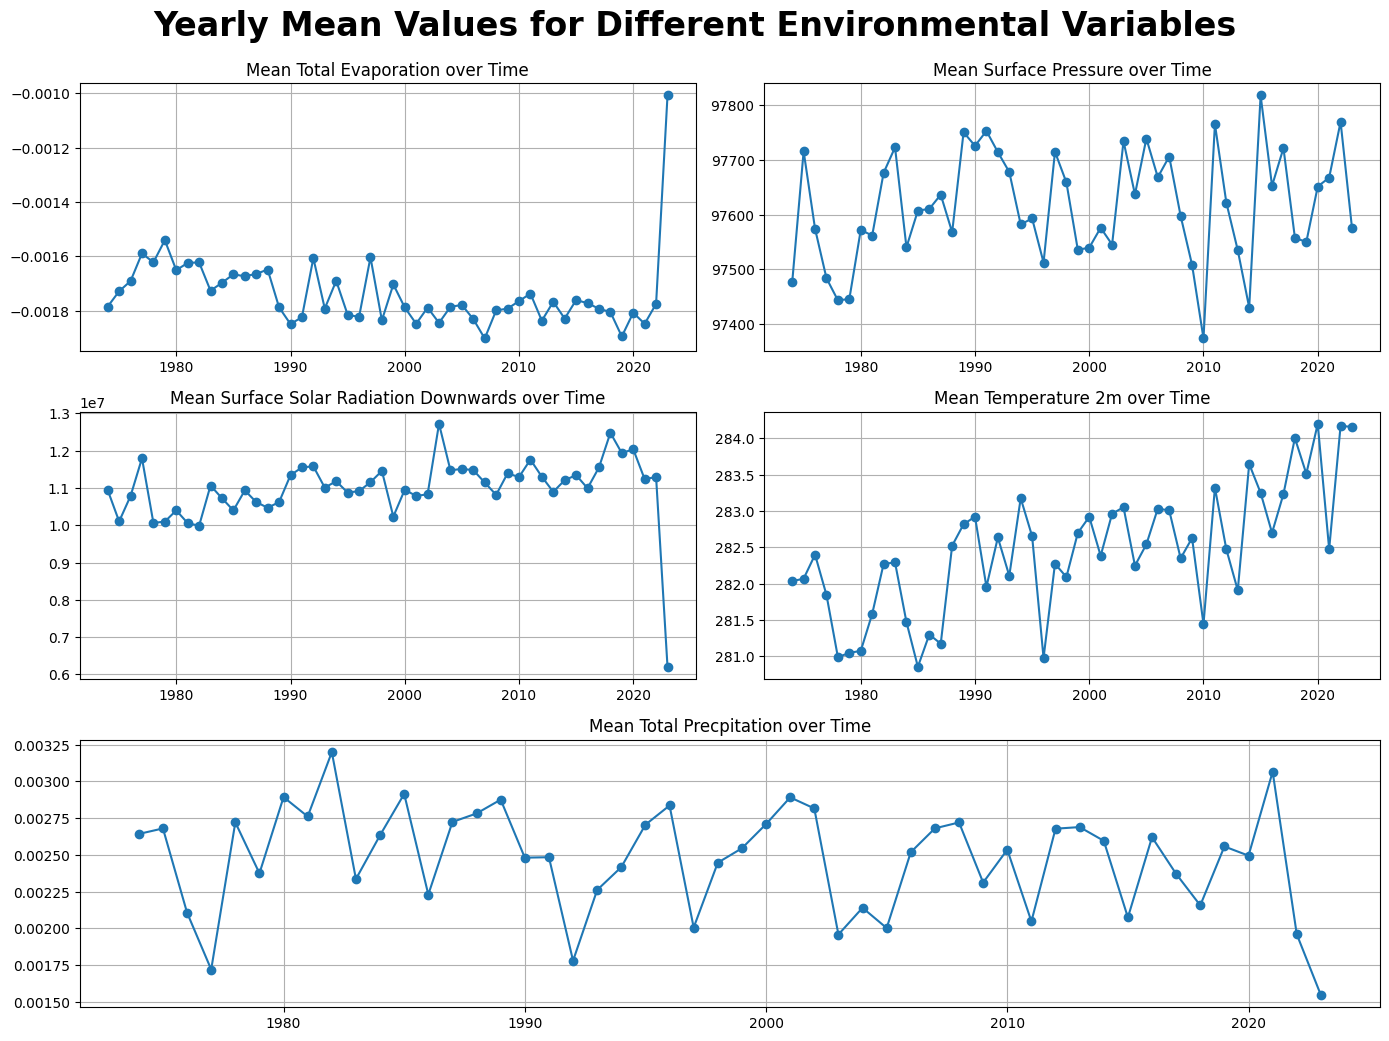

In [6]:
def plot_columns_mean(df: pd.DataFrame, saveplot: bool = False) -> None:
    """
    Plots the mean of each column in the DataFrame over time.

    Parameters:
        - df (pd.DataFrame): DataFrame containing the data to plot. Must include a 'year' column.
        - saveplot (bool): If True, saves the plot to a file. Default is False.
    """
    df_grouped = df.groupby("year").mean().reset_index()
    columns_to_plot = df_grouped.columns.difference(["year"])
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    axes = axes.flatten()
    for i, col in enumerate(columns_to_plot):
        if i == 4:
            fig.delaxes(axes[4])
            fig.delaxes(axes[5])
            axes[i] = plt.subplot2grid((3, 2), (2, 0), colspan=2)
        axes[i].plot(df_grouped["year"], df_grouped[col], label=col, marker="o")
        axes[i].set_title(f"Mean {VARIABLES_MAP[col]} over Time")
        axes[i].grid(True)
    fig.text(0.5, 1.02, "Yearly Mean Values for Different Environmental Variables", ha="center", va="center", fontsize=24, fontweight="bold")
    plt.tight_layout()
    if saveplot:
        plt.savefig("data/means.jpg", dpi=300, bbox_inches='tight')
    plt.show()
plot_columns_mean(df, saveplot=False)

#### 2.2. Distribution Plot

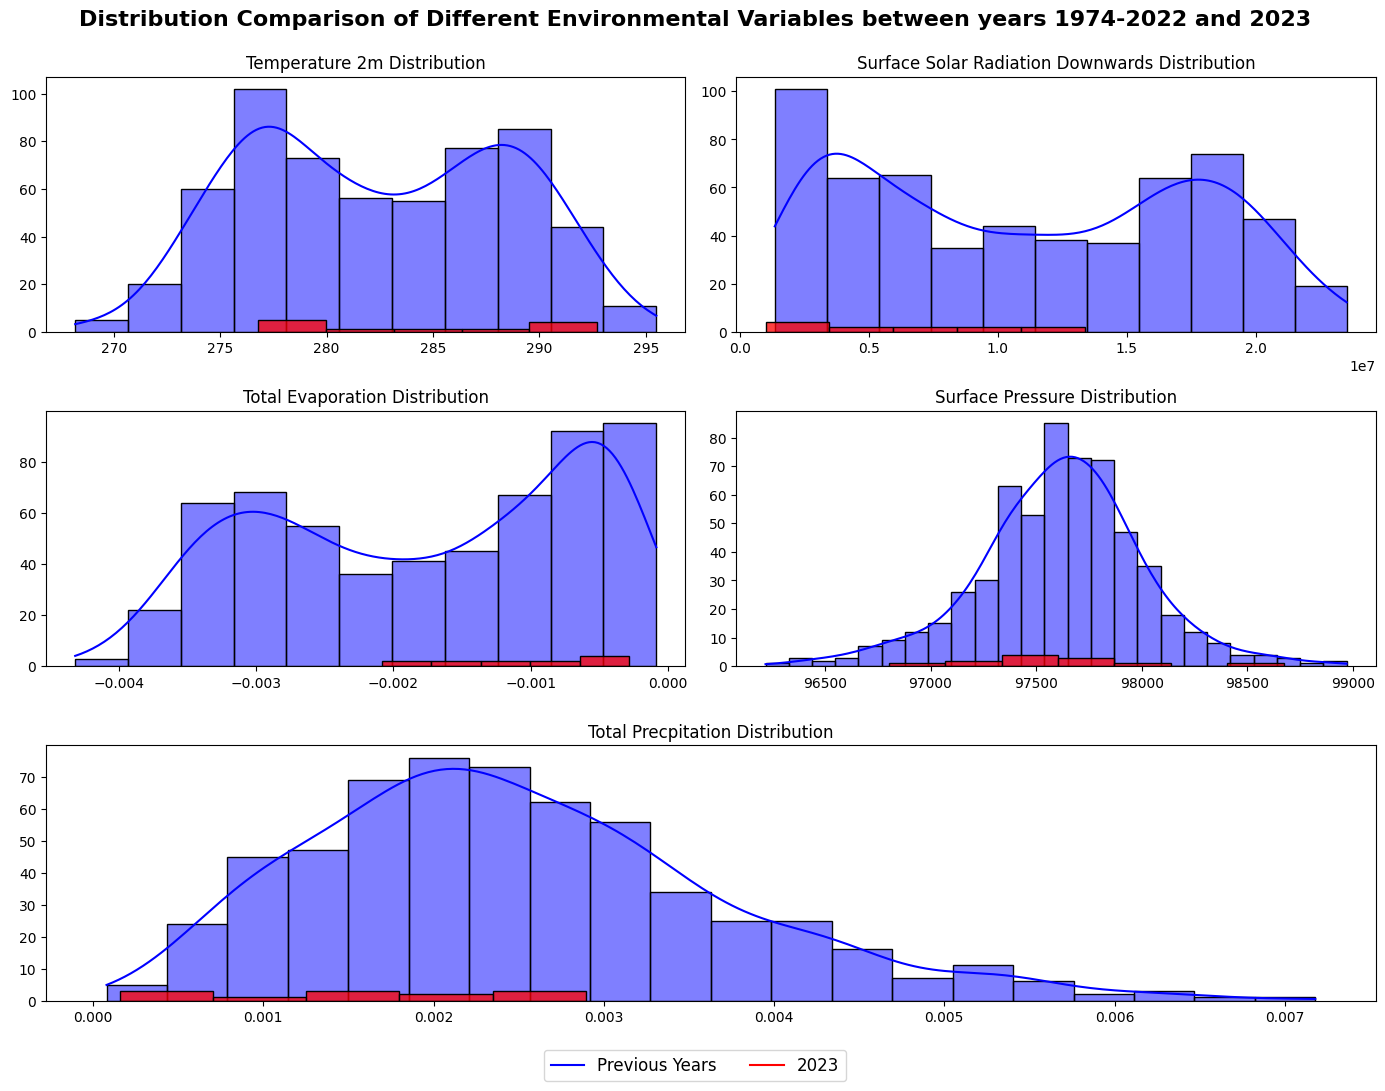

In [7]:
def compare_distributions(df: pd.DataFrame, variables: list[str] = VARIABLES, saveplot: bool = False) -> None:
    """
    Compares the distribution of selected variables for the year 2023 and previous years using histograms.

    Parameters:
        - df (pd.DataFrame): The DataFrame containing the data to plot. Must include a 'year' column.
        - variables (list[str]): A list of variable names (columns) to compare distributions for.
        - saveplot (bool): If True, saves the plot as an image file. Default is False.
    """
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    axes = axes.flatten()
    for i, var in enumerate(variables):
        if i == 4:
            fig.delaxes(axes[4])
            fig.delaxes(axes[5])
            axes[i] = plt.subplot2grid((3, 2), (2, 0), colspan=2)
        sns.histplot(df[df['year'] < 2023][var], label='Previous Years', color='blue', kde=True, ax=axes[i])
        sns.histplot(df[df['year'] == 2023][var], label='2023', color='red', kde=False, ax=axes[i])
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].set_title(f'{VARIABLES_MAP[var]} Distribution')

    # create custom legend handles
    custom_lines = [
        plt.Line2D([0], [0], color='blue', label='Previous Years'),
        plt.Line2D([0], [0], color='red', label='2023')
    ]
    # add a single legend at the bottom of the figure
    fig.legend(handles=custom_lines, loc='lower center', fontsize=12, ncol=2, bbox_to_anchor=(0.5, -0.05))
    fig.text(0.5, 1.02, "Distribution Comparison of Different Environmental Variables between years 1974-2022 and 2023", ha="center", va="center", fontsize=16, fontweight="bold")
    plt.tight_layout()
    if saveplot:
        plt.savefig("data/distributions.jpg", dpi=300, bbox_inches='tight')
    plt.show()
compare_distributions(df, saveplot=False)


Now we are ready to preprocess the data. We observed & will perform the following:
1. The raw data is clean: There are no `NaN` values and all values are in proper format.
2. We notice from plot above that year $2023$ seems like an outlier: `e`, `ssrd`, `tp` are too extreme compared to previous years. Even though the values for these variables for year $2023$ lie in highly probable range (see histogram above), we ultimately decide to remove data related to year $2023$ because of these extreme values.
3. We convert `e` (total evaporation) from negative to positive scale.

In [8]:
def preproces_data(data_path: str = DATA_PATH_2023, save_path: str = DATA_PATH) -> None:
    """
    Preprocesses the dataset:
        - Load the dataset from a CSV file.
        - Check for missing values and raising an error if any are found.
        - Remove data entries from the year 2023.
        - Convert the 'e' column (total evaporation) values to their absolute values.
        - Save the modified DataFrame back to the CSV file.

    Parameters:
        - data_path (str): The file path of the dataset to preprocess. Default is DATA_PATH_2023.
        - save_path (str): The file path to save the preprocessed data. Default is DATA_PATH.
    """
    df = pd.read_csv(data_path)
    if df.isna().any().any():
        raise ValueError("The dataset contains missing values. Handle manually.")
    # remove data from 2023
    df = df.loc[df["year"] != 2023]
    # convert evaporation from negative to positive scale
    df["e"] = np.abs(df["e"])
    df.to_csv(save_path, index=False)
preproces_data()

In [9]:
df = pd.read_csv(DATA_PATH)
df

,t2m,ssrd,e,sp,tp,year
0,277.29285,3131412.0,0.000300,97800.625,0.001762,1974
1,276.57672,4690008.0,0.001012,97040.440,0.005246,1974
2,279.25210,10824857.0,0.001415,97388.800,0.002257,1974
3,281.77430,16904724.0,0.002493,97375.414,0.001554,1974
4,284.07626,17102084.0,0.002909,97414.120,0.002379,1974
...,...,...,...,...,...,...
583,294.13995,19442848.0,0.002748,97712.530,0.001050,2022
584,287.14697,6568349.5,0.000963,97378.050,0.001365,2022
585,286.55950,3968206.0,0.000604,97905.590,0.002089,2022
586,280.85040,2136010.0,0.000409,97358.790,0.001449,2022


### 3. Summary Statistics

We will use the following statistical measures for the summary statistics plot & table: **mean**, **median**, **variance**, **minimum** and **maximum**.

In [10]:
def plot_summary(summary_grouped: pd.DataFrame, statistics: list[str] = ["mean", "median", "var", "min", "max"], window: int = 5, saveplot: bool = False) -> None:
    """
    Plots the summary statistics for each variable across different years, along with a rolling average for smoothing.

    Parameters:
        - summary_grouped (pd.DataFrame): The DataFrame containing grouped summary statistics (mean, median, etc.) for each variable.
        - statistics (list[str]): List of summary statistics to plot for each variable. Defaults to ["mean", "median", "var", "min", "max"].
        - window (int): The window size for calculating the rolling average. Defaults to 5.
        - saveplot (bool): If True, saves the plot to a file. Default is False.
    """
    # create a figure with 5 rows and 5 columns
    fig, axes = plt.subplots(5, 5, figsize=(20, 12))
    # variables to plot
    variables = summary_grouped.columns.levels[0]
    # plot each variable's summary statistics across the years
    for i, variable in enumerate(variables):
        for j, stat in enumerate(statistics):
            ax = axes[i, j]
            # retrieve statistic value for a variable
            data = summary_grouped[variable][stat]
            # plot statistic for variable
            data.plot(ax=ax, marker='o')
            # plot rolling average to smooth the data
            rolling_avg = data.rolling(window=window).mean()
            rolling_avg.plot(ax=ax, color='red', linestyle='--')
            ax.set_xlabel("")
        axes[i, 0].set_ylabel(VARIABLES_MAP[variable], fontsize=10, labelpad=10)
        axes[i, 0].yaxis.set_label_position("left")
    for i, stat in enumerate(statistics):
        axes[0, i].set_title(stat, fontsize=14)
    # create a single legend for the whole figure
    # create custom handles for the legend
    custom_lines = [
        plt.Line2D([0], [0], color='blue', marker='o', label='Statistic value'),
        plt.Line2D([0], [0], color='red', linestyle='--', label='Moving average')
    ]
    # add the legend to the figure
    fig.legend(handles=custom_lines, loc='upper right', fontsize=12, bbox_to_anchor=(0.58, -0.01))
    # show plot
    plt.tight_layout()
    fig.text(0.5, 1.02, "Summary Statistics for Different Environmental Variables", ha="center", va="center", fontsize=24, fontweight="bold")
    if saveplot:
        plt.savefig("data/summary.jpg", dpi=300, bbox_inches='tight')
    plt.show()

def calculate_summary(df: pd.DataFrame, saveplot: bool = False) -> pd.DataFrame:
    """
    Calculates summary statistics for each variable in the DataFrame and plots the results over time using plot_summary() function.

    Parameters:
        - df (pd.DataFrame): The input DataFrame containing data to summarize, where one of the columns must be 'year'.
        - saveplot (bool): If True, saves the plot to a file. Default is False.

    Returns:
        - summary (pd.Dataframe): DataFrame containing the summary statistics (mean, median, variance, min, max) for all variables in the DataFrame, excluding the 'year' column.
    """
    summary_grouped = df.groupby("year").agg(["mean", "median", "var", "min", "max"])
    summary = df.agg(["mean", "median", "var", "min", "max"]).drop(columns=["year"])
    plot_summary(summary_grouped=summary_grouped, saveplot=saveplot)
    return summary

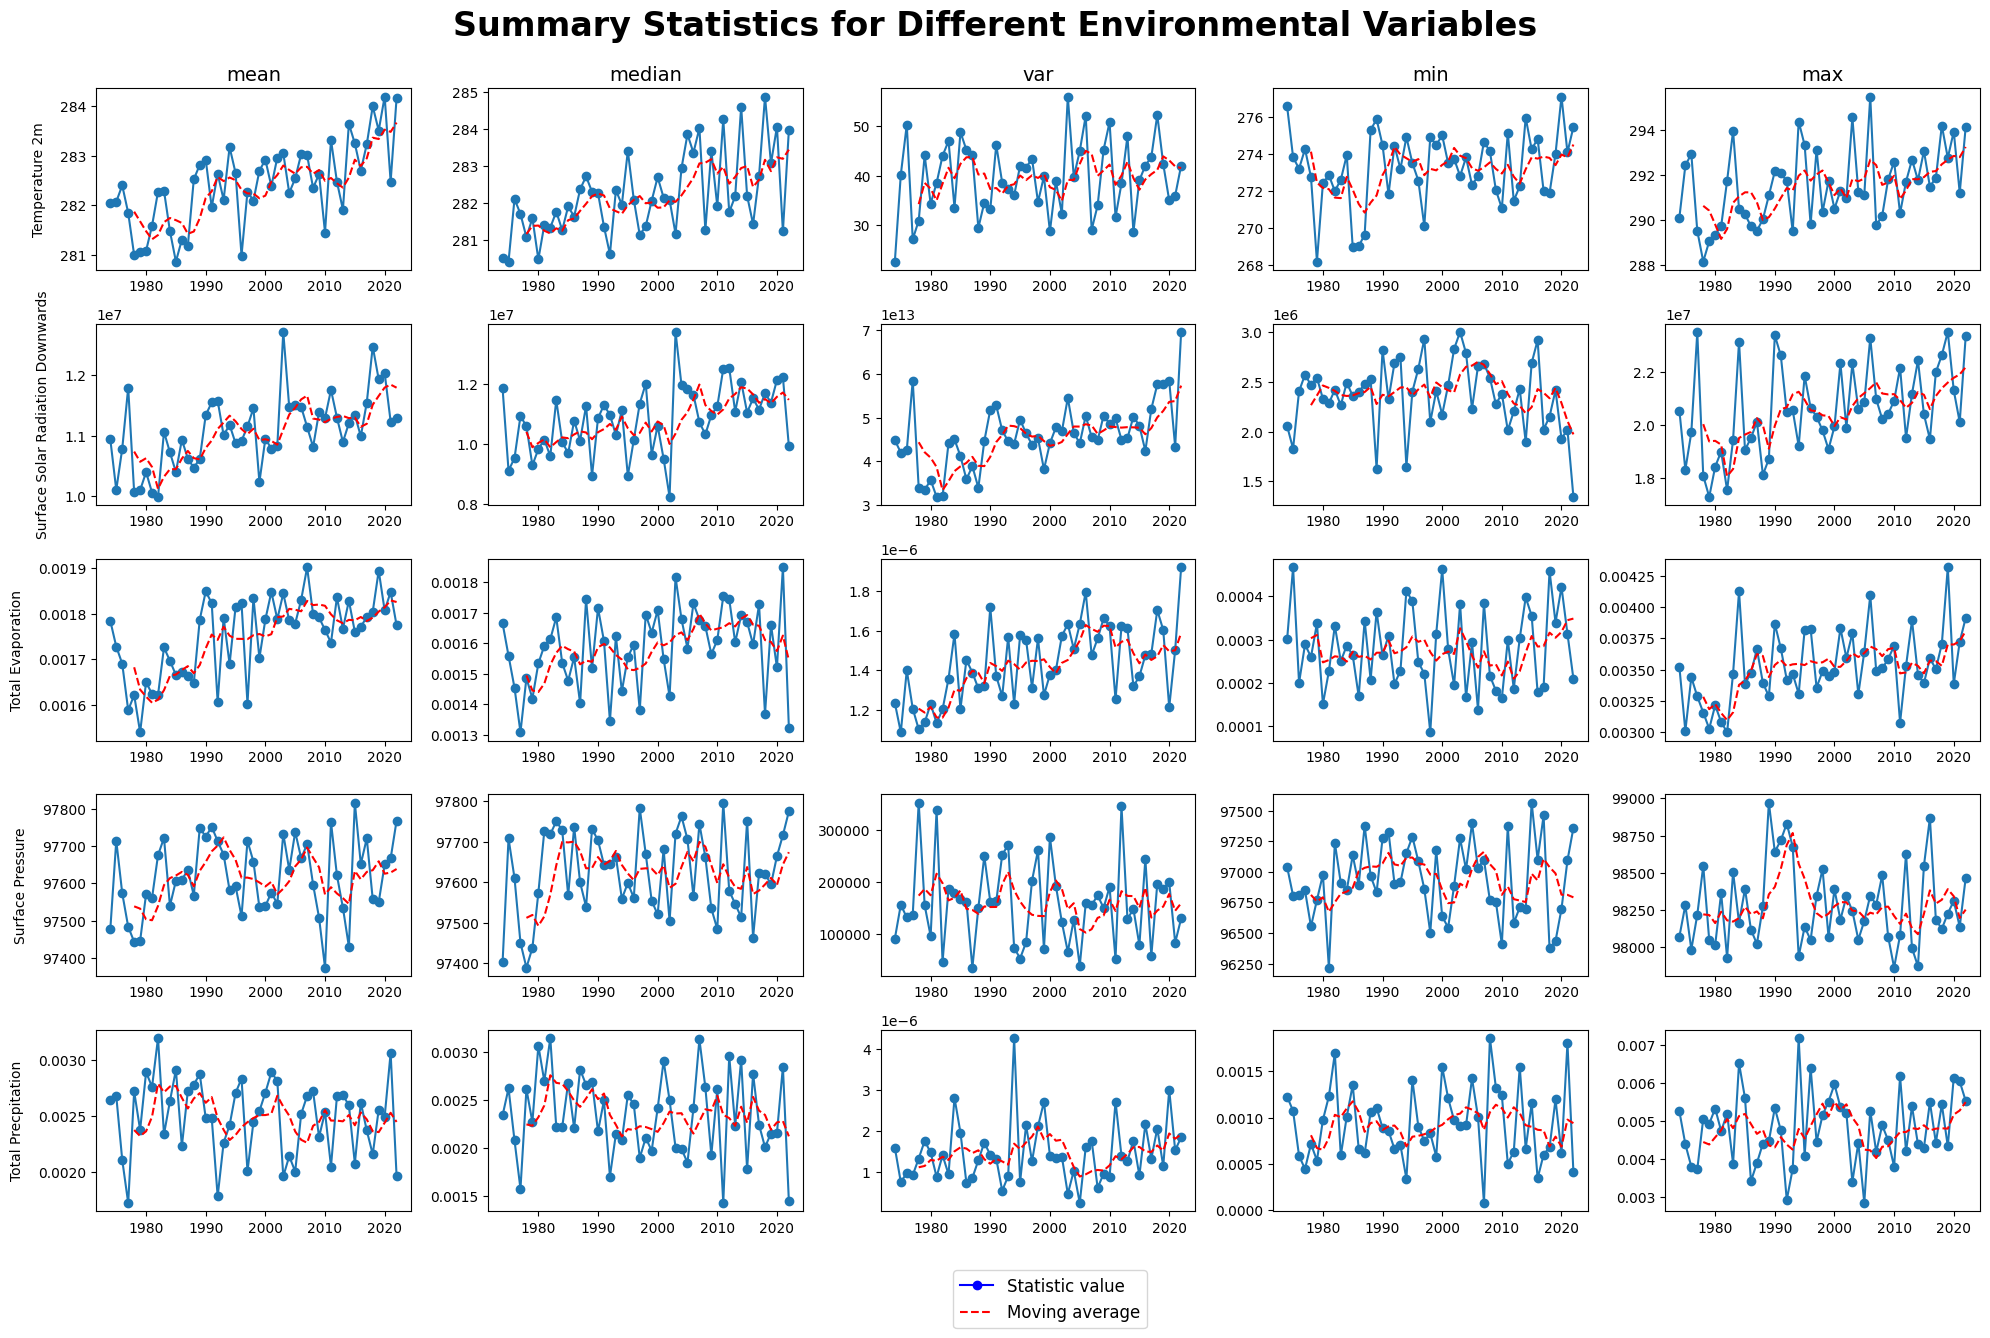

,t2m,ssrd,e,sp,tp
mean,282.422346,1.107641e+07,0.001751,97616.47083,0.002494
median,282.128540,1.095859e+07,0.001585,97628.67250,0.002344
var,36.988568,4.239948e+13,0.000001,155287.66908,0.000001
min,268.188780,1.345306e+06,0.000086,96218.16000,0.000079
max,295.495480,2.353309e+07,0.004316,98971.14000,0.007179


In [11]:
df = pd.read_csv(DATA_PATH)
summary = calculate_summary(df, saveplot=False)
summary

### 6. Correlation Analysis

To perform correlation analysis we will use the Pearson correlation coefficient, which can be used to summarize the strength of the linear relationship between two variables.

$$\text{Pearson} = \frac{\text{COV}(X, Y)}{\text{STD}(X) \cdot \text{STD}(Y)}$$

Note that the Pearson correlation coefficient is used for continious variables, which works in our case.

In [12]:
def calculate_pvalues(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs significance testing for each correlation

    Parameters:
        - df (pd.DataFrame): DataFrame containing the data.
    
    Returns:
        - pvalues (pd.Dataframe): Dataframe containing p-values.
    """
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

         t2m    ssrd       e      sp      tp
e        0.0     0.0     0.0  0.7346  0.1032
sp    0.0269  0.6338  0.7346     0.0     0.0
ssrd     0.0     0.0     0.0  0.6338     0.0
t2m      0.0     0.0     0.0  0.0269  0.0124
tp    0.0124     0.0  0.1032     0.0     0.0


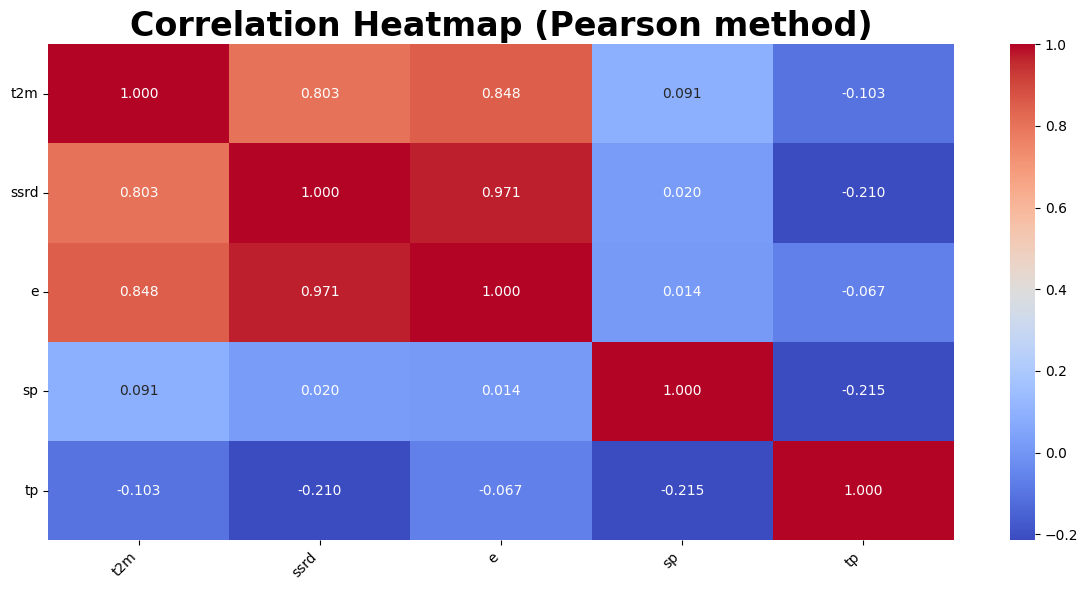

In [13]:
def calculate_plot_correlation(df: pd.DataFrame, method: str = "pearson", saveplot=False) -> None:
    """
    Calculates and plots a heatmap of the correlation matrix for the given DataFrame.

    Parameters:
        - df (pd.DataFrame): DataFrame containing the data.
        - method (str): The method of correlation ('pearson', 'spearman', or 'kendall'). Default is 'pearson'.
        - saveplot (bool): If True, saves the plot to a file. Default is False.
    """
    # exclude the 'year' column
    df = df.loc[:, df.columns != 'year']
    # calculate correlation coefficients
    corr = df.corr(method=method)
    # calculate p-values
    p_values = calculate_pvalues(df=df)
    print(round(p_values, 3))
    # plot the heatmap for the correlation matrix
    plt.figure(figsize=(12, 6))
    sns.heatmap(corr, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
    plt.title(f'Correlation Heatmap ({method.capitalize()} method)', fontsize=24, fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    if saveplot:
        plt.savefig("data/correlations.jpg", dpi=300, bbox_inches='tight')
    plt.show()
calculate_plot_correlation(df, saveplot=False)

From the *p-values* table and correlation heatmap we get:
- Significant Correlations (*p-value* $< 0.05$):
    - **t2m** and **e**: *p-value* $= 0.0$
    - **t2m** and **ssrd**: *p-value* $= 0.0$
    - **t2m** and **tp**: *p-value* $= 0.012$
    - **t2m** and **sp**: *p-value* $= 0.027$
    - **ssrd** and **e**: *p-value* $= 0.0$
    - **ssrd** and **tp**: *p-value* $= 0.0$
    - **sp** and **tp**: *p-value* $= 0.0$
- Statistically Insignificant Correlations (*p-value* $> 0.05$):
    - **ssrd** and **sp**: *p-value* $= 0.634$
    - **e** and **sp**: *p-value* $= 0.735$
    - **e** and **tp**: *p-value* $= 0.103$

Most of these correlations are self-explanatory. For example, there is a positive correlation between temperature and surface solar radition, which is natural: radiant energy from the Sun transforms into thermal energy. We can summarize the correlations as follows:
- Positive correlations: 
    - **t2m** and **ssrd**: Solar radiation is a major driver of surface temperature. Increased solar radiation heats the surface, causing an increase in temperature.
    - **t2m** and **e**: Higher surface temperatures promote more evaporation, as warmer air has a higher capacity to hold water vapor. This can increase evaporation rates from bodies of water, soil, and vegetation.
    - **ssrd** and **e**: More solar radiation provides the energy needed for evaporation. As solar radiation increases, more energy is available to convert liquid water into vapor, leading to higher evaporation rates.
- Negative correlations:
    - **t2m** and **tp**: This inverse relationship shows that higher surface temperatures are be associated with lower precipitation, i.e. drier and hotter conditions reduce precipitation.
    - **ssrd** and **tp**: High solar radiation values typically occur during clear skies, which indicate drier conditions with less cloud cover and less precipitation.
    - **sp** and **tp**: Higher surface pressure is associated with anticyclonic conditions, which are typically dry and stable, leading to less precipitation.
- No correaltions:
    - **t2m** and **sp**: The weak relationship between surface temperature and surface pressure indicates that these two variables do not directly influence each other in a significant way. Which is natural, since atmospheric pressure is caused by the force of gravity.

### 7. Trend Analysis

In this part we will be analyzing the Temperature 2m over the years. To do so we will fit a regression model to our data using the ```statsmodels``` library and plot the trend line for our data with ```matplotlib``` for visualization. Finally we will analyze and interpret the observed results.

                            OLS Regression Results                            
Dep. Variable:                    t2m   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.918
Date:                Mon, 07 Oct 2024   Prob (F-statistic):             0.0270
Time:                        20:21:39   Log-Likelihood:                -1892.9
No. Observations:                 588   AIC:                             3790.
Df Residuals:                     586   BIC:                             3799.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        204.1045     35.318      5.779      0.0

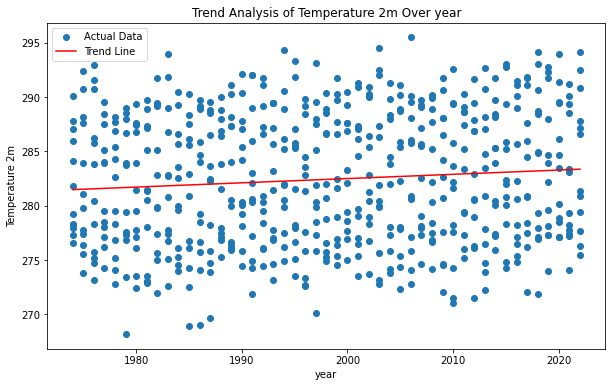

In [32]:
def plot_trend(df: pd.DataFrame, ivar: str = 'year', dvar: str = 't2m') -> None:
    """
    fits a linear regression model and generates a plot of the regression line to analyze the variable's trend

    Parameters:
        - df (pd.DataFrame): DataFrame containing the data.
        - ivar (str): the independent variable for our trend analysis
        - dvar (bool): the dependent variable for our trend analysis
    """
    
    # data preparation
    X = df[ivar] 
    y = df[dvar]
    X = sm.add_constant(X)
    
    # fit the linear regression model
    model = sm.OLS(y, X).fit()

    # print the model summary
    print(model.summary())

    # plot the regression line and data points
    plt.figure(figsize=(10,6))
    plt.scatter(df[ivar], df[dvar], label='Actual Data')
    plt.plot(df[ivar], model.predict(X), color='red', label='Trend Line')

    plt.title(f'Trend Analysis of {VARIABLES_MAP[dvar]} Over {ivar}')
    plt.xlabel(ivar)
    plt.ylabel(VARIABLES_MAP[dvar])
    plt.legend()
    plt.show()    
    
plot_trend(df)

#### **Summary and Plot Interpretation**

Looking at the regression model's summary and the trend line we can derive the following conclusions

1. Coefficient for year
    - at **0.0392** this means that ```t2m``` increases by 0.0392 approximately every year
    - with the **p-value** for the year coefficient at **0.027** (<0.05) this indicates a statistically significant temperature increase over time at 5% significance level
2. R-squared and F-statistic
    - with a very low R-squared value of **0.008** means that only 0.8% of the variability in teamprature is explained by the year
    - F-statistic is **4.918** with a p-value of **0.0270**, which again shows that the model is statistically significant overall
3. Durbin-Watson and Prob(JB)
    - The Durbin-Watson statistic is **0.378**, which is quite low and indicates that there may be some autocorrelation in the residuals
    - The very low p-value of the Jarque-Bera test  **(6.44e-08)** suggests that the residuals are not normally distributed.
4. Plot
    - The scatter plot shows that the temperature varies a lot over years but the slight increase in temperature (slope of 0.0392) is still visually visible on th ered line

## 8. Report

Please see the detailed discussion in the attached report file.